# SimpleConv2d
## Name: Nguyen Anh Hoang Phuc

We will build from scratch a class of convolutional neural networks (CNNs) for 2D, implementing the algorithms using only minimal libraries such as NumPy.

We will also create a pooling layer and so on to complete the basic form of the CNN. The name of the class should be Scratch2dCNNClassifier.

Preparing the dataset

We continue to use the MNIST dataset, entering the 2D convolutional layer in a 28x28 state.

In this case, there is only one channel because it is a black and white image, but the axis in the channel direction must be prepared.

(n_samples, n_channels, height, width)in the form of eitherNCHWor(n_samples, height, width, n_channels)in the form ofNHWC.

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt

# Evaluation index
from sklearn.metrics import accuracy_score

In [2]:
# Download the MNIST dataset
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

In [3]:
# Check the data
print(X.shape) #(60000, 28, 28)
print(X_test.shape) #(10000, 28, 28)
print(X[0].dtype) #uint8

(60000, 28, 28)
(10000, 28, 28)
uint8


In [4]:
# Type conversion, normalization
X = X.astype(np.float)
X_test = X_test.astype(np.float)
X /= 255
X_test /= 255
print(X.max()) # 1.0
print(X.min()) # 0.0

1.0
0.0


In [5]:
# One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:,np.newaxis])
y_test_one_hot = enc.transform(y_test[:,np.newaxis])
print(y.shape) #(60000,)
print(y_one_hot.shape) #(60000, 10)
print(y_one_hot.dtype) #float64

(60000,)
(60000, 10)
float64


In [6]:
# Split into training data and validation data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y_one_hot, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 28, 28)
(12000, 28, 28)
(48000, 10)
(12000, 10)


## Prepare for NN classes and other activities so far
### All binding layers

In [7]:
class FC:
  """
  All coupling layers from number of nodes n_nodes1 to n_nodes2
  Parameters
  ==========
  n_nodes1: int
    Number of nodes in the previous layer
  n_nodes2: int
    Number of nodes in subsequent layers
  initializer: Instances of initialization methods
  optimizer: Instances of optimizations methods
  """
  def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
    
    self.n_nodes1 = n_nodes1
    self.n_nodes2 = n_nodes2
    self.initializer = initializer
    self.optimizer = optimizer
    self.activation = activation
    # Initialize
    # Use the initializer method to initialize self.w and self.B
    self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
    self.B = self.initializer.B(self.n_nodes2)

  def forward(self, X):
    """
    forward
    Parameters
    ==========
    X: ndarray of the following form, shape (batch_size, n_nodes1)
      Input
    Returns
    ==========
    A: ndarray of the following form, shape (batch_size, n_nodes2)
      Output
    """
    self.X = X
    self.A = np.dot(self.X, self.W) + self.B

    return self.activation.forward(self.A)

  def backward(self, dZ):
    """
    backward
    Parameters
    ==========
    dA: ndarray of the following form, shape (batch_size, n_nodes2)
      The gradient flowed in from behind
    Returns
    ==========
    dZ: ndarray of the following form, shape (batch_size, n_nodes1)
      forward slope
    """
    dA = self.activation.backward(dZ)
    self.dB = np.mean(dA, axis=0)
    self.dW = np.dot(self.X.T, dA)/len(self.X)
    dZ = np.dot(dA, self.W.T)

    # Update
    self = self.optimizer.update(self)

    return dZ

### Initialization

In [8]:
class SimpleInitializerConv2d:
  """
  Simple initialization with Gaussian distribution
  Parameters
  ==========
  sigma: float
    Standard deviation of Gaussian distribution
  """
  def __init__(self, sigma=0.01):
    self.sigma = sigma

  def W(self, F, C, FH, FW):
    """
    Initializing weights
    Parameters
    ==========
    
    Returns
    ==========
    W: weight
    """
    return self.sigma * np.random.randn(F,C,FH,FW)
    
  def B(self, F):
    """
    Bias initialization
    Parameters
    ==========
    
    Returns
    ==========
    B: bias
    """
    return np.zeros(F)

In [9]:
class SimpleInitializer:
  """
  Simple initialization with Gaussian distribution
  Parameters
  ==========
  sigma: float
    Standard deviation of Gaussian distribution
  """
  def __init__(self, sigma):
    self.sigma = sigma

  def W(self, n_nodes1, n_nodes2):
    """
    Initializing weights
    Parameters
    ==========
    n_nodes1: int
      Number of nodes in the previous layer
    n_nodes2: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    W: weight
    """
    return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
  def B(self, n_nodes2):
    """
    Bias initialization
    Parameters
    ==========
    n_nodes2: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    B: bias
    """
    return np.zeros(n_nodes2)

In [10]:
class HeInitializer():
  """
  Initialization of weights by He
  """
  def __init__(self):
    pass
  
  def W(self, n_nodes1, n_nodes2):
    """
    Initializing weights
    Parameters
    ==========
    n_nodes1: int
      Number of nodes in the previous layer
    n_nodes2: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    W: weight
    """
    return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)

  def B(self, n_nodes2):
    """
    Bias initialization
    Parameters
    ==========
    n_nodes2: int
      Number of nodes in subsequent layers
    
    Returns
    ==========
    B: bias
    """
    return np.zeros(n_nodes2)

### Optimization

In [11]:
class SGD:
  """
  stochastic gradient descent method
  Parameters
  ==========
  lr: learning rate
  """
  def __init__(self, lr=0.01):
    self.lr = lr 
  
  def update(self, layer):
    """
    Updating the weights and biases of a layer
    Parameters
    ==========
    layers: As instance of the layer before the update
    """
    layer.W -= self.lr*layer.dW
    layer.B -= self.lr*layer.dB

    return layer

In [12]:
class AdaGrad:
  """
  Parameters
  ==========
  lr: learning rate
  """
  def __init__(self, lr):
    self.lr = lr
    self.hW = 0
    self.hB = 0
  
  def update(self, layer):
    """
    Updating the weights and biases of a layer
    Parameters
    ==========
    layer: An instance of the layer before the update
    """
    self.hW += layer.dW*layer.dW
    self.hB = layer.dB*layer.dB

    layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
    layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)

    return layer

### Activation function

In [13]:
class ReLU():
  """
  Activation function: ReLU function
  """
  def __init__(self):
    pass
  
  def forward(self, A):
    self.A = A
    return np.maximum(self.A,0)
  
  def backward(self, dZ):
    return np.where(self.A>0,dZ,0)

In [14]:
class Softmax():
  """
  Activation function: Softmax function
  """
  def __init__(self):
    pass
  
  def forward(self, A):
    return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)), axis=1, keepdims=True)
  
  def backward(self, dZ):
    return dZ

### Mini-batch

In [15]:
# Mini-batch processing class
class GetMiniBatch:
  """
  Iterator to get the mini-batch

  Parameters
  ===========
  X: ndarray of the following form, shape (n_samples, n_features)
     Training data
  y: ndarray of the following form, shape (n_samples, 1)
     Correct value
  batch_size: int
     Batch size
  seed: int
     Seeding random numbers in NumPy
  """
  def __init__(self, X, y, batch_size = 20, seed=None):
    self.batch_size = batch_size
    np.random.seed(seed)
    shuffle_index = np.random.permutation(np.arange(X.shape[0]))
    self._X = X[shuffle_index]
    self._y = y[shuffle_index]
    self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

  def __len__(self):
    return self._stop

  def __getitem__(self, item):
    p0 = item*self.batch_size
    p1 = item*self.batch_size + self.batch_size
    return self._X[p0:p1], self._y[p0:p1]

  def __iter__(self):
    self._counter = 0
    return self
  
  def __next__(self):
    if self._counter >= self._stop:
      raise StopIteration()
    p0 = self._counter*self.batch_size
    p1 = self._counter*self.batch_size + self.batch_size
    self._counter += 1
    return self._X[p0:p1], self._y[p0:p1]

## 【Problem 1】Creating a 2-D convolutional layer

Develop the class Conv1d for 1D convolutional layers and create the class Conv2d for 2D convolutional layers.

The formula for forward propagation is as follows

$a_{i, j, m}=\sum_{k=0}^{K-1} \sum_{s=0}^{F_{h}-1} \sum_{t=0}^{F_{w}-1} x_{(i+s),(j+t), k} w_{s, t, k, m}+b_{m}$

$a_{i,j,m}$: i-th row, j-th column, m-channel value of the output array

$i$: Array row index

$j$: the column index of the array

$m$: Output channel index

$K$: Number of input channels

$F_{h}, F_{w}$: Filter size in height (h) and width (w)

$x_{(i+s),(j+t),k}$: (i+s) row (j+t) column, k channel value of the input array

$w_{s,t,k,m}$: sth and tth column of the weight array. Weight to be output to the m channel for the input of the k channel

$b_m$: Bias term of output to m channel

All are scalars.

Next is the update formula, which has the same form as for 1D convolutional and all-combining layers.

$w_{s, t, k, m}^{\prime}=w_{s, t, k, m}-\alpha \frac{\partial L}{\partial w_{s, t, k, m}}$

$b_{m}^{\prime}=b_{m}-\alpha^{\frac{\partial L}{\partial b_{m}}}$

$\alpha$: learning rate

$\frac{\partial L}{\partial w_{s,t,k,m}}$: Loss $L$ gradient with respect to $w_{s,t,k,m}$

$\frac{\partial L}{\partial b_{m}}$: Loss $L$ slope for $b_{m}$

Of back propagation to find the gradients $\frac{\partial L}{\partial w_{s,t,k,m}}$ and $\frac{\partial L}{\partial b_{m}}$ The formula is:

$\frac{\partial L}{\partial w_{s, t, k, m}}=\sum_{i=0}^{N_{o u t, h}-1} \sum_{j=0}^{N_{o u t, w}-1} \frac{\partial L}{\partial a_{i, j, m}} x_{(i+s)(j+t), k}$

$\frac{\partial L}{\partial b_{m}}=\sum_{i=0}^{N_{o u, h}-1} \sum_{j=0}^{N_{o u t, w}-1} \frac{\partial L}{\partial a_{i, j, m}}$

$\frac{\partial L}{\partial a_i}$: i-row, j-column, m-channel value of the gradient array

$N_{out,h},N_{out,w}$: Size of output in height direction (h) and width direction (w)

The formula for the error to be passed to the previous layer is as follows

$\frac{\partial L}{\partial x_{i, j, k}}=\sum_{m=0}^{M-1} \sum_{s=0}^{F_{h}-1} \sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t), m}} w_{s, t, k, m}$

$\frac{\partial L}{\partial x_{i,j,k}}$: i column, j row, k channel value of the error array to be passed to the previous layer

$M$: Number of output channels

However, when $is<0$ or $is>N_{out,h}-1$ or $jt<0$ or $jt>N_{out,w}-1$, $\frac{\partial L}{ \partial a_{(is),(jt),m}} =0$.


In [16]:
# 2d convolutional layer class
class SimpleConv2d():
  """
  2D convolutional layer
  Parameters
  ==========
  initializer: Instances of initialization methods
  optimizer: Instances of optimizations methods
  """
  def __init__(self, F, C, FH, FW, P, S, initializer=None, optimizer=None, activation=None):
    self.P = P
    self.S = S
    self.initializer = initializer
    self.optimizer = optimizer
    self.activation = activation

    # Initialize
    # Use the initializer method to initialize self.W and self.B
    self.W = self.initializer.W(F, C, FH, FW)
    self.B = self.initializer.B(F)

  def output_shape2d(self,H,W,PH,PW,FH,FW,SH,SW):
    OH = (H+2*PH-FH)/SH + 1
    OW = (W+2*PW-FW)/SW + 1
    return int(OH), int(OW)

  def forward(self, X):
    """
    forward
    Parameters
    ==========
    X: ndarray of the following form, shape (batch_size, n_nodes1)
      Input
    Returns
    ==========
    A: ndarray of the following form, shape (batch_size, n_nodes2)
      Output
    """
    self.X = X
    # Size
    N, C, H, W = self.X.shape
    F, C, FH, FW = self.W.shape

    OH, OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S, self.S)

    self.params = N,C,H,W,F,FH,FW,OH,OW

    A = np.zeros([N,F,OH,OW])

    self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P,self.P), (self.P,self.P)))

    # Batch
    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(0,H,self.S):
          # Horizontal Slide
          for col in range(0,W,self.S):
            A[n,ch,row, col] = np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]*self.W[ch,:,:,:]) + self.B[ch]
    
    return self.activation.forward(A)

  def backward(self, dZ):
    """
    backward
    Parameters
    ==========
    dA: ndarray of the following form, shape (batch_size, n_nodes2)
      The gradient flowed in from behind
    Returns
    ==========
    dZ: ndarray of the following form, shape (batch_size, n_nodes1)
      forward slope
    """
    dA = self.activation.backward(dZ)
    N,C,H,W,F,FH,FW,OH,OW = self.params

    dZ = np.zeros(self.X_pad.shape)
    self.dW = np.zeros(self.W.shape)
    self.dB = np.zeros(self.B.shape)

    # dZ
    # Batch
    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(0,H,self.S):
          # Horizontal Slide
          for col in range(0,W,self.S):
              dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
    
    dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
    dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)

    dZ = np.delete(dZ,dl_rows,axis=2)
    dZ = np.delete(dZ,dl_cols,axis=3)

    # dW
    # Batch
    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(OH):
          # Horizontal Slide
          for col in range(OW):
            self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]

    # dB
    # Output channels
    for ch in range(F):
      self.dB[ch] = np.sum(dA[:,ch,:,:])

    # Update
    self = self.optimizer.update(self)

    return dZ

## [Problem 2] Output size after 2-dimensional convolution
Convolution changes the size of the feature map.

How it changes can be obtained from the following formula.

Create a function to do this calculation.

$N_{h, \text { out }}=\frac{N_{h, \text { in }}+2 P_{h}-F_{h}}{S_{h}}+1$

$N_{w, \text { out }}=\frac{N_{w, \text { in }}+2 P_{w}-F_{w}}{S_{w}}+1$

$N_{out}$: Output size (number of features)

$N_{in}$: Input size (number of features)

$P$: Number of paddings in one direction

$F$: Filter size

$S$: Stride size

$h$ is the height direction, $w$ is the width direction

In [17]:
def output_shape2d(IH=5,IW=5,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1):
  OH = (IH + 2*PH - FH)/SH +1
  OW = (IW + 2*PW - FW)/SW +1
  return int(OH), int(OW)

In [18]:
print(output_shape2d(IH=6,IW=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1))

(4, 4)


### Experiment with 2D convolution

In [19]:
N,C,H,W = (5,1,28,28)
F,C,FH,FW = (4,1,3,3)

S = 1 #Fixed for now
P = 1

OH, OW = output_shape2d(H,W,P,P,FH,FW,S,S)

A = np.zeros([N,F,OH,OW])

X_sample = X[0:N].reshape(N,C,H,W)
X_pad = np.pad(X_sample,((0,0),(0,0),(P,P),(P,P)))
w = np.ones([F,C,FH,FW])
B = np.ones(F)

# Forward

# Batch
for n in range(N):
  # Output channels
  for ch in range(F):
    # Vertical slide
    for row in range(0,H,S):
      # Horizontal Slide
      for col in range(0,W,S):
        A[n,ch,row,col] = np.sum(X_pad[n,:,row:row+FH,col:col+FW]*w[ch,:,:,:])+B[ch]
print('A.shape:',A.shape)

A.shape: (5, 4, 28, 28)


In [20]:
# Backward
dA = np.ones(A.shape)

dZ = np.zeros(X_pad.shape)
dW = np.zeros(w.shape)
dB = np.zeros(B.shape)

# dZ 
# Batch
for n in range(N):
  # Output channels
  for ch in range(F):
    # Vertical slide
    for row in range(0,H,S):
      # Horizontal slide
      for col in range(0,W,S):
        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*w[ch,:,:,:]

dl_rows = range(P),range(H+P,H+2*P,1)
dl_cols = range(P),range(W+P,W+2*P,1)

dZ = np.delete(dZ,dl_rows,axis=2)
dZ = np.delete(dZ,dl_cols,axis=3)

# dW
# Batch
for n in range(N):
  # Output channels
  for ch in range(F):
    # Vertical slide
    for row in range(OH):
      # Horizontal slide
      for col in range(OW):
        dW[ch,:,:,:] += dA[n,ch,row,col]*X_pad[n,:,row:row+FH,col:col+FW]
  
# dB
# Output channels
for ch in range(F):
  dB[ch] = np.sum(dA[:,ch,:,:])

print('dZ.shape:',dZ.shape)
print('dW.shape:',dW.shape)
print('dB.shape:',dB.shape)

dZ.shape: (5, 1, 28, 28)
dW.shape: (4, 1, 3, 3)
dB.shape: (4,)


## [Problem 3] Creation of maximum pooling layer

Create a class MaxPool2D for the maximum pooling layer. Some parts of the pooling layer are easier to understand if they are not expressed in mathematical terms, but if they are expressed in mathematical terms, the forward propagation looks like this

$a_{i, j, k}=\max _{(p, q) \in P_{i, j}} x_{p, q, k}$

$P_{i,j}$: A set of input array indices for output to i row and j column. Row (p) and column (q) within the range of $S_{h}×S_{w}$

$S_{h}, S_{w}$: Height (h) and width (w) stride size

$(p,q)\in P_{i,j}$: Index of row (p) and column (q) included in $P_{i,j}$

$a_{i,j,m}$: i-th row, j-th column, k-channel value of the output array

$x_{p,q,k}$: p-by-q, k-channel value of the input array

Within a certain range, the maximum value is calculated, leaving the axis in the channel direction unchanged.

For backpropagation, it is necessary to retain the maximum index $(p,q)$ in forward propagation. This is because the error is sent as it is to the part that had the maximum value at the time of forward, and 0 is put in other parts.

In [21]:
class MaxPool2D():

  def __init__(self, P):
    self.P = P
    self.PA = None
    self.Pindex = None

  def forward(self,A):
    N,F,OH,OW = A.shape
    PS = self.P
    PH, PW = int(OH/PS), int(OW/PS)

    self.params = N,F,OH,OW,PS,PH,PW

    # Pooling filter
    self.PA = np.zeros([N,F,PH,PW])
    self.Pindex = np.zeros([N,F,PH,PW])

    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(PH):
          # Horizontal slide
          for col in range(PW):
            self.PA[n,ch,row,col] = np.max(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])

            self.Pindex[n,ch,row,col] = np.argmax(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
    return self.PA

  def backward(self,dA):

    N,F,OH,OW,PS,PH,PW = self.params
    dP = np.zeros([N,F,OH,OW])

    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(PH):
          # Horizontal slide
          for col in range(PW):
            idx = self.Pindex[n,ch,row,col]
            tmp = np.zeros((PS*PS))
            for i in range(PS*PS):
              if i == idx:
                tmp[i] = dA[n,ch,row,col]
              else:
                tmp[i] = 0
            dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
    return dP

In [22]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print(X)

[[[[6 1 3 7 2 0]
   [1 6 8 2 1 1]
   [1 2 7 0 7 3]
   [7 0 3 8 2 5]
   [3 3 0 4 1 5]
   [4 0 0 0 6 7]]]]


In [23]:
Pooling = MaxPool2D(P=2)
A = Pooling.forward(X)

print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[6. 8. 2.]
   [7. 8. 7.]
   [4. 4. 7.]]]]


In [24]:
Pooling.Pindex

array([[[[0., 2., 0.],
         [2., 3., 0.],
         [2., 1., 3.]]]])

In [25]:
dA = np.random.randint(0,9,9).reshape(A.shape)
print(dA)

[[[[4 6 0]
   [7 3 3]
   [4 2 7]]]]


In [26]:
dZ = Pooling.backward(dA)
print(dZ)

[[[[4. 0. 0. 0. 0. 0.]
   [0. 0. 6. 0. 0. 0.]
   [0. 0. 0. 0. 3. 0.]
   [7. 0. 0. 3. 0. 0.]
   [0. 0. 0. 2. 0. 0.]
   [4. 0. 0. 0. 0. 7.]]]]


## [Problem 4] (Advance task) Creating average pooling

Create a class AveragePool2D for the average pooling layer.

This is a pooling layer where the output is an average value rather than the maximum value in a range.

In image recognition, the maximum pooling layer is commonly used, while the average pooling is less commonly used.

In [27]:
class AveragePool2D():

  def __init__(self, P):
    self.P = P
    self.PA = None
    self.Pindex = None

  def forward(self,A):
    N,F,OH,OW = A.shape
    PS = self.P
    PH, PW = int(OH/PS), int(OW/PS)

    self.params = N,F,OH,OW,PS,PH,PW

    # Pooling filter
    self.PA = np.zeros([N,F,PH,PW])

    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(PH):
          # Horizontal slide
          for col in range(PW):
            self.PA[n,ch,row,col] = np.mean(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])

    return self.PA

  def backward(self,dA):

    N,F,OH,OW,PS,PH,PW = self.params
    dP = np.zeros([N,F,OH,OW])

    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(PH):
          # Horizontal slide
          for col in range(PW):
            tmp = np.zeros((PS*PS))
            for i in range(PS*PS):
              tmp[i] = dA[n,ch,row,col]/(PS*PS)
            dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
    return dP

In [28]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print(X)

[[[[6 1 4 7 6 2]
   [7 5 0 5 1 4]
   [0 5 6 4 4 7]
   [4 1 6 3 0 8]
   [6 4 1 0 7 8]
   [2 2 3 6 8 7]]]]


In [29]:
Pooling = AveragePool2D(P=2)
A = Pooling.forward(X)

print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[4.75 4.   3.25]
   [2.5  4.75 4.75]
   [3.5  2.5  7.5 ]]]]


In [30]:
dA = np.random.randint(0,9,9).reshape(A.shape)
print(dA)

[[[[1 0 4]
   [1 5 0]
   [2 6 7]]]]


In [31]:
dZ = Pooling.backward(dA)
print(dZ)

[[[[0.25 0.25 0.   0.   1.   1.  ]
   [0.25 0.25 0.   0.   1.   1.  ]
   [0.25 0.25 1.25 1.25 0.   0.  ]
   [0.25 0.25 1.25 1.25 0.   0.  ]
   [0.5  0.5  1.5  1.5  1.75 1.75]
   [0.5  0.5  1.5  1.5  1.75 1.75]]]]


## [Problem 5] Smoothing

Create a Flatten class for smoothing.

In the forward direction, the three dimensions of channel, height and width are reshaped to one dimension. The values are recorded and reshaped again in the backward direction.

By interposing this class of smoothing, we can create an array suitable for all the combined layers before the output.

In [32]:
class Flatten:
  def __init__(self,):
    pass
  def forward(self,X):
    self.shape = X.shape
    return X.reshape(len(X),-1)
  def backward(self,X):
    return X.reshape(self.shape)

In [33]:
TEST = np.zeros([20,2,5,5])
flt = Flatten()
flat_forward = flt.forward(TEST)
print('Forward_shape:', flat_forward.shape)
print('Backward_shape:', flt.backward(flat_forward).shape)

Forward_shape: (20, 50)
Backward_shape: (20, 2, 5, 5)


## [Problem 6] Learning and estimation

Use the created Conv2d to train and estimate MNIST and calculate the Accuracy.

Aim to move first, even if the accuracy is low.

In [34]:
# Scratch CNN
class Scratch2dCNNClacssifier():
  """
  N-Layer Convolutional Neural Network Classifier

  Parameters
  ==========
  self.n_epoch: epoch number
  self.n_batch: Number of batches
  self.verbose: Visualizing the learning process
  Attributes
  ==========
  """
  def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose=False):
    # Parameters
    self.n_epoch = n_epoch
    self.n_batch = n_batch 
    self.verbose = verbose
    self.log_loss = np.zeros(self.n_epoch)
    self.log_acc = np.zeros(self.n_epoch)
    self.NN = NN
    self.CNN = CNN

  def loss_function(self,y,yt):
    delta = 1e-7
    return -np.mean(yt*np.log(y+delta))

  def accuracy(self, Z, Y):
    return accuracy_score(Y, Z)

  def predict(self, X):
      """
      Estimate using a neural network classifier

      Parameters
      ==========
      X: ndarray of the following form, shape (n_samples, n_features)
        Sample
      
      Returns
      ==========
         ndarray of the following form, shape (n_samples, 1)
         Estimation results
      """
      pred_data = X[:,np.newaxis,:]

      # Conv
      for layer in range(len(self.CNN)):
        pred_data = self.CNN[layer].forward(pred_data)
      
      pred_data = flt.forward(pred_data)

      for layer in range(len(self.NN)):
        pred_data = self.NN[layer].forward(pred_data)

      return np.argmax(pred_data, axis=1)

  def fit(self, X, y, X_val=False, y_val=False):
    """
    Train a neural network classifier.

    Parameters
    ==========
    X: ndarray of the following form, shape (n_samples, n_features)
      Features of training data
    y: ndarray of the following form, shape (n_samples, )
      Correct answer value of training data
    X_val: ndarray of the following form, shape (n_samples, n_features)
      Features of validation data
    y_val: ndarray of the following form, shape (n_samples, )
      Correct value of validation data
    """
    for epoch in range(self.n_epoch):
      # Mini-batch processing 
      get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

      self.loss = 0
      for mini_X_train, mini_y_train in get_mini_batch:

        # Forward propagation
        forward_data = mini_X_train[:,np.newaxis,:,:]

        # Conv
        for layer in range(len(self.CNN)):
          forward_data = self.CNN[layer].forward(forward_data)
        
        # Flatten
        flt = Flatten()
        forward_data = flt.forward(forward_data)

        # NN
        for layer in range(len(self.NN)):
          forward_data = self.NN[layer].forward(forward_data)

        # Predicted value
        Z = forward_data

        # Back propagation
        backward_data = (Z - mini_y_train)/self.n_batch
        for layer in range(len(self.NN)-1,-1,-1):
          backward_data = self.NN[layer].backward(backward_data)
        
        backward_data = flt.backward(backward_data)

        for layer in range(len(self.CNN)-1,-1,-1):
          backward_data = self.CNN[layer].backward(backward_data)
        
        # Loss function
        self.loss += self.loss_function(Z, mini_y_train)

      self.log_loss[epoch] = self.loss/len(get_mini_batch)
      self.log_acc[epoch] = self.accuracy(self.predict(X), np.argmax(y, axis=1))
      if self.verbose:
        print("Epoch: {}, loss: {}, acc: {}".format(epoch, self.log_loss[epoch], self.log_acc[epoch]))

In [58]:
# All bonding layers
NN = {0:FC(15680, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
      1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
      2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
      }

In [59]:
CNN = {0:SimpleConv2d(F=20, C=1, FH=3, FW=3, P=1, S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU()),
      }

In [60]:
cnn1 = Scratch2dCNNClacssifier(NN=NN,CNN=CNN,n_epoch=10,n_batch=200,verbose=True)

cnn1.fit(X_train[0:1000], y_train[0:1000])

Epoch: 0, loss: 0.2159751298319419, acc: 0.195
Epoch: 1, loss: 0.22476108163653724, acc: 0.156
Epoch: 2, loss: 0.26479068828568664, acc: 0.269
Epoch: 3, loss: 0.18984965922165314, acc: 0.614
Epoch: 4, loss: 0.15598749013021695, acc: 0.668
Epoch: 5, loss: 0.09375859671773108, acc: 0.796
Epoch: 6, loss: 0.06950852019020318, acc: 0.808
Epoch: 7, loss: 0.05977793275937817, acc: 0.862
Epoch: 8, loss: 0.044048237023016495, acc: 0.894
Epoch: 9, loss: 0.039022737333340884, acc: 0.867


In [61]:
# Estimate
y_pred = cnn1.predict(X_valid[0:100])

# Positive solution rate
accuracy = accuracy_score(np.argmax(y_valid[0:100],axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.850


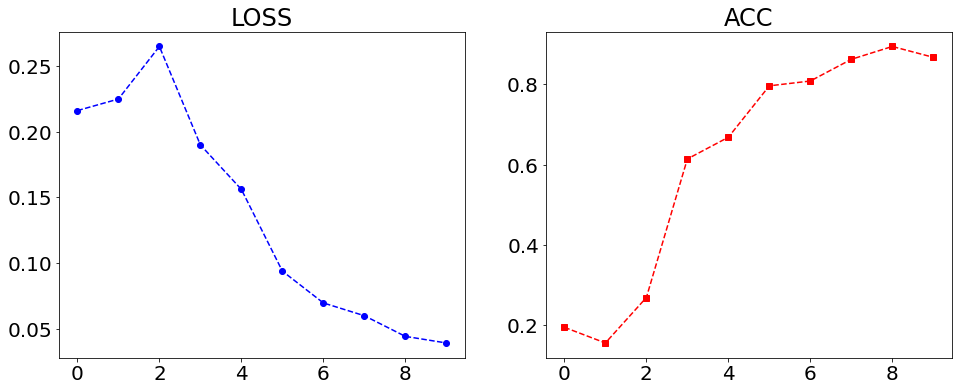

In [62]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("LOSS")
plt.plot(cnn1.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title("ACC")
plt.plot(cnn1.log_acc, 'rs--')

## [Problem 7] (Advance assignment) LeNet

When performing image recognition with CNNs, it is common to use well-known structures instead of considering filter size and number of layers from scratch. The most historically important one is LeNet from 1998, although it is no longer in practical use today. You can reproduce this structure and run it against MNIST to calculate the Accuracy.

Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.

In [35]:
# LeNet structure
# Convolutional layers
LeNetCNN = {0:SimpleConv2d(F=6, C=1, FH=5, FW=5, P=2, S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU()),
       1:MaxPool2D(P=2),
       2:SimpleConv2d(F=16, C=6, FH=5, FW=5, P=2, S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU()),
       3:MaxPool2D(P=2),
      }

# All bonding layers
LeNetNN = {0:FC(784, 120, HeInitializer(), AdaGrad(0.01), ReLU()),
           1:FC(120, 84, HeInitializer(), AdaGrad(0.01), ReLU()),
           2:FC(84, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
          }
# Learning        
LeNet = Scratch2dCNNClacssifier(NN=LeNetNN,CNN=LeNetCNN,n_epoch=10,n_batch=20,verbose=True)

LeNet.fit(X_train, y_train)

Epoch: 0, loss: 0.03429407475963432, acc: 0.9624375
Epoch: 1, loss: 0.010251793423887656, acc: 0.9732708333333333
Epoch: 2, loss: 0.007956608859658801, acc: 0.978375
Epoch: 3, loss: 0.006896973897070572, acc: 0.9835416666666666
Epoch: 4, loss: 0.006085236742712387, acc: 0.9843333333333333
Epoch: 5, loss: 0.00558011221205359, acc: 0.9867291666666667
Epoch: 6, loss: 0.005389015088764252, acc: 0.9852708333333333
Epoch: 7, loss: 0.005188783477124724, acc: 0.976875
Epoch: 8, loss: 0.0049860324274385815, acc: 0.9856458333333333
Epoch: 9, loss: 0.004569879949898329, acc: 0.9854375


In [36]:
# Estimate
y_pred_LeNet = LeNet.predict(X_valid)

# Positive solution rate
accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred_LeNet)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.978


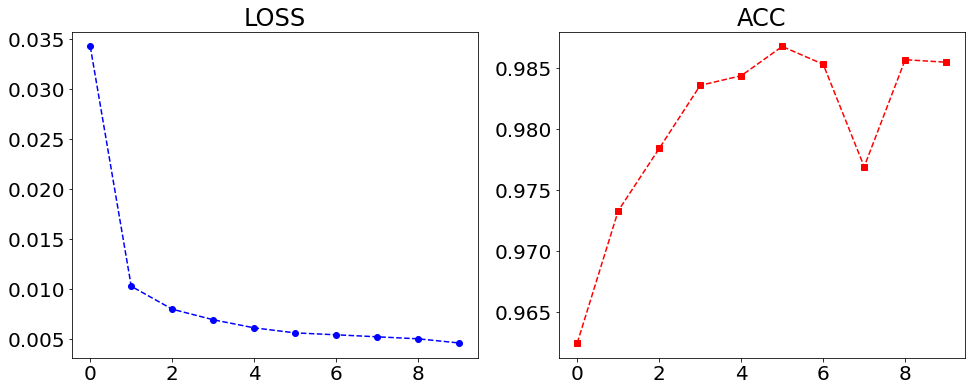

In [37]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("LOSS")
plt.plot(LeNet.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title("ACC")
plt.plot(LeNet.log_acc, 'rs--')

## [Problem 8] (Advance assignment) Survey of famous image recognition models

Typical CNN structures include AlexNet (2012) and VGG16 (2014). Many of these are already available in frameworks.

Please do a brief research on what they are and summarize them. It is a good idea to at least look at the names.

《Reference》

Applications-Keras Documentation

Famous CNN structures
<li> AlexNet(2012)
<li> ZFNet(2013)
<li> GoogleNet(2014)
<li> VGGNet(2014)
<li> Resnet(2015)
<li> SENet(2017)

## [Problem 9] Calculation of output size and number of parameters

When building a CNN model, it is necessary to pre-compute the number of features at the stage of input to the full join layer.

Also, when dealing with huge models, the number of parameters becomes essential due to memory and calculation speed. The framework can show you the number of parameters in each layer, but you need to understand the meaning of the parameters to be able to adjust them appropriately.

Calculate the output size and the number of parameters for the following three convolution layers. For the number of parameters, please also consider the bias term.

1.

    Input size : 144 x 144, 3 channels
    Filter size: 3 x 3, 6 channels
    Stride : 1
    Padding: none
-> Output size: 6x142x142, Number of parameters: 168 (Weight 162, Bias 6)

2.

    Input size : 60x60, 24 channels
    Filter size: 3 x 3, 48 channels
    Stride : 1
    Padding: none
-> Output size: 48x58x58, Number of parameters: 10416(Weight 10368, Bias 48)

3.

    Input size : 20x20, 10 channels
    Filter size: 3 x 3, 20 channels
    Stride: 2
    Padding: none
-> Output size: 20x9x9, Number of parameters: 1820(Weight 1800, Bias 20)


The last example is a case where you can't get the convolution just right. The framework sometimes does not look at the extra pixels, so consider that when calculating. This is an example of why such a setting is not desirable, as it will result in missing edges.

## [Problem 10] (Advance assignment) Survey on filter size

Convolutional layers have a hyperparameter called filter size, which is mostly used nowadays in 2D convolutional layers: 3×3 and 1×1. Please look up each of the following and explain them in your own way.

<li> Why 3×3 filters are commonly used instead of larger ones such as 7×7
-> Because the number of parameters would be huge. (Size squared)
Because the purpose of convolution is to extract features (including positional relationships) between input parameters. Increasing the filter size is contrary to the purpose
<li> The effect of a 1 x 1 filter with no height or width direction
-> By reducing the number of output channels from the input channels, the number of parameters can be reduced
-> If the number is odd, the center of the filter is defined, but if the number is even, the center is not defined
